In [1]:
%pip install rasterio
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
import gc
from skimage.metrics import peak_signal_noise_ratio, structural_similarity, mean_squared_error
from scipy.stats import pearsonr
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import reproject
import glob
import os
import scipy
from scipy.ndimage import gaussian_filter, laplace
from scipy.optimize import minimize

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: C:\Users\Dhruv\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'

In [3]:
def crop_and_straighten(img, threshold=10, visualize=False):
    if len(img.shape) == 2 or img.shape[2] == 1:
        gray = img if len(img.shape) == 2 else img[:, :, 0]
    else:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Normalize to 8-bit for contour processing
    gray_8bit = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)
    gray_8bit = gray_8bit.astype(np.uint8)

    # Create binary mask for valid region
    _, mask = cv2.threshold(gray_8bit, threshold, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        raise ValueError("No valid region found!")

    # Largest contour
    cnt = max(contours, key=cv2.contourArea)
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.intp(box)
    # print(box)

    width, height = int(rect[1][0]), int(rect[1][1])
    dst_pts = np.array([[0, height-1],
                        [0, 0],
                        [width-1, 0],
                        [width-1, height-1]], dtype="float32")
    src_pts = box.astype("float32")

    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warped = cv2.warpPerspective(img, M, (width, height))

    if visualize:
        plt.imshow(warped, cmap='gray' if len(warped.shape) == 2 else None)
        plt.title("Straightened & Cropped Image")
        plt.axis("off")
        plt.show()

    return warped


def compute_quality_metrics(ref_img, test_img, PSNR=True):
    assert ref_img.shape == test_img.shape, "Images must have the same shape"
    assert ref_img.ndim == 3, "Images must be H x W x C"

    psnr_list = []
    cc_list = []
    ssim_list = []
    rmse_list = []

    for i in range(ref_img.shape[2]):
        ref_band = ref_img[:, :, i].astype(np.float64)
        test_band = test_img[:, :, i].astype(np.float64)

        # Use fixed data range for uint16 images
        data_range = 65535.0

        if PSNR:
          psnr_val = peak_signal_noise_ratio(ref_band, test_band, data_range=data_range)
          psnr_list.append(psnr_val)


        # cc_val, _ = pearsonr(ref_band.flatten(), test_band.flatten())
        # ssim_val = structural_similarity(ref_band, test_band, data_range=data_range)
        else:
          rmse_val = np.sqrt(mean_squared_error(ref_band, test_band))
          mean_ref = np.mean(ref_band)
          rel_rmse = rmse_val / mean_ref if mean_ref != 0 else 0
          rmse_list.append(rel_rmse)


        # cc_list.append(cc_val)
        # ssim_list.append(ssim_val)

        if PSNR:
            return {
              "PSNR": np.mean(psnr_list)
            }
        else:
            return {
                "RMSE": np.mean(rmse_list)
            }

def calculate_ergas(original_ms, pansharpened_ms, ratio):
    if original_ms.shape != pansharpened_ms.shape:
        raise ValueError("Images must be the same shape. Resample the original MS image first.")

    N = original_ms.shape[2]
    ergas_sum = 0

    for i in range(N):
        ref_band = original_ms[:, :, i].astype(np.float64)
        pan_band = pansharpened_ms[:, :, i].astype(np.float64)

        rmse = np.sqrt(mean_squared_error(ref_band, pan_band))
        mean_val = np.mean(ref_band)

        ergas_sum += (rmse / mean_val) ** 2

    ergas = 100 * (ratio) * np.sqrt(ergas_sum / N)
    return ergas


def compute_sam(img1, img2, eps=1e-8):
    # Flatten spatial dimensions
    X = img1.reshape(-1, img1.shape[-1]).astype(np.float32)
    Y = img2.reshape(-1, img2.shape[-1]).astype(np.float32)

    # Compute dot product and norms
    dot_product = np.sum(X * Y, axis=1)
    norm_x = np.linalg.norm(X, axis=1)
    norm_y = np.linalg.norm(Y, axis=1)

    # Avoid division by zero
    denom = np.clip(norm_x * norm_y, eps, None)

    # Compute angle (in radians)
    sam = np.arccos(np.clip(dot_product / denom, -1.0, 1.0))
    sam_map = sam.reshape(img1.shape[0], img1.shape[1])

    mean_sam = np.mean(sam)

    sam_map_safe = np.clip(sam_map, 1e-6, None)

    # Normalize to [0, 1]
    sam_map_norm = sam_map_safe / np.max(sam_map_safe)

    # Apply log transform
    sam_log = np.log1p(sam_map_norm)  # log(1 + x)

    # Normalize again and scale to 0-255
    sam_log_norm = (sam_log / np.max(sam_log)) * 255
    return sam_log_norm.astype(np.uint8) , mean_sam

def visualize_sam_map(sam_map, cmap='inferno'):
    plt.figure(figsize=(8, 6))
    plt.imshow(np.degrees(sam_map), cmap=cmap)
    plt.colorbar(label='SAM (degrees)')
    plt.title("Spectral Angle Mapper (SAM) Map")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [4]:
# Read the TIFF image
image_b = tiff.imread("data\LC08_L1TP_B2.tiff")
image_g = tiff.imread("data\LC08_L1TP_B3.tiff")
image_r = tiff.imread("data\LC08_L1TP_B4.tiff")
image_ir = tiff.imread("data\LC08_L1TP_B5.tiff")
image_pan = tiff.imread("data\LC08_L1TP_B8.tiff")

# Check if image is loaded successfully
if image_b is None:
    print("Failed to load image.")
else:
    print("Image shape:", image_b.shape)
    # Display the image

Image shape: (7951, 7821)


In [5]:
print("blue band shape:", image_b.shape)
print("red band shape:", image_r.shape)
print("green band shape:", image_g.shape)
print("NIR band shape:", image_ir.shape)
print("PAN band shape:", image_pan.shape)

blue band shape: (7951, 7821)
red band shape: (7951, 7821)
green band shape: (7951, 7821)
NIR band shape: (7951, 7821)
PAN band shape: (15901, 15641)


In [6]:
image_b_ = crop_and_straighten(image_b,visualize=False);
image_g_ = crop_and_straighten(image_g,visualize=False);
image_r_ = crop_and_straighten(image_r,visualize=False);
image_ir_ = crop_and_straighten(image_ir,visualize=False);
image_pan_ = crop_and_straighten(image_pan,visualize=False);

In [7]:
print(image_b_.shape)
print(image_g_.shape)
print(image_r_.shape)
print(image_ir_.shape)
print(image_pan_.shape)

(6552, 6350)
(6552, 6351)
(6552, 6350)
(6552, 6351)
(13105, 12715)


In [8]:
image_b_ =  cv2.resize(image_b_, (6348, 6550), interpolation=cv2.INTER_LINEAR)
image_r_ =  cv2.resize(image_r_, (6348, 6550), interpolation=cv2.INTER_LINEAR)
image_g_ =  cv2.resize(image_g_, (6348, 6550), interpolation=cv2.INTER_LINEAR)
image_ir_ =  cv2.resize(image_ir_, (6348, 6550), interpolation=cv2.INTER_LINEAR)

In [9]:
ms_image = np.stack([image_b_,image_g_,image_r_,image_ir_],axis=-1)

In [10]:
ms_image.shape

(6550, 6348, 4)

In [11]:
def blur(image, sigma=1.2):
    """Apply Gaussian blur to simulate sensor MTF."""
    return gaussian_filter(image, sigma=sigma)


def synth_pan(z, lambdas):
    """Simulate PAN image from multispectral image using spectral weights."""
    return np.tensordot(lambdas, z, axes=(0, 0))  # shape (H, W)


def loss_map_sar(Z, Y, x, lambdas, alpha, beta):
    """Compute the MAP loss with SAR prior."""
    B, H, W  = Z.shape
    loss_val = 0.0

    for b in range(B):
        zb = Z[b]
        yb = Y[b]
        smooth = laplace(zb)
        loss_val += beta * np.sum((blur(zb) - yb) ** 2)
        loss_val += alpha * np.sum(smooth ** 2)

    x_hat = synth_pan(Z, lambdas)
    loss_val += beta * np.sum((x_hat - x) ** 2)

    return loss_val

In [12]:
(pan_height,pan_width) = image_pan_.shape[:2]
ms_image_resize = cv2.resize(ms_image, (pan_width, pan_height), interpolation=cv2.INTER_LINEAR)

In [13]:
ms_image_resize.shape

(13105, 12715, 4)

In [ ]:
def optimize_map_sar_gd(Y, x, lambdas, alpha=0.001, beta=1.0, sigma_blur=1.2, lr=0.05, max_iter=50):
    """
    Gradient descent of MAP-SAR
    """
    Y = Y.astype(np.float32)
    x = x.astype(np.float32)
    Z = Y.copy()
    for it in range(max_iter):
        grad = np.zeros_like(Z)

        for b in range(Z.shape[0]):
            zb = Z[b]
            yb = Y[b]

            # Gradient of the MS term
            diff_ms = blur(zb) - yb
            grad_ms = gaussian_filter(diff_ms, sigma=sigma_blur)

            # Gradient of SAR prior (Laplacian)
            grad_sar = laplace(laplace(zb))  # second derivative

            # Gradient of the PAN term
            pan_residual = synth_pan(Z) - x
            grad_pan = lambdas[b] * pan_residual

            grad[b] = beta * grad_ms + alpha * grad_sar + beta * grad_pan

        # Gradient descent update
        Z -= lr * grad

        if it % 10 == 0:
            print(f"Iteration {it}: gradient norm = {np.linalg.norm(grad):.2f}") # doesn't have to go to zero, just 1e-3 times the original ideally

    return Z


In [15]:
gc.collect()

615

In [ ]:
ms_image_resized = ms_image_resize.astype(np.float32)
Y = np.transpose(ms_image_resized, (2, 0, 1))  # shape: (4, H, W)

# PAN image
x = image_pan_.astype(np.float32)  # shape: (H, W)

# Set PAN weights (adjust based on sensor, or use uniform if unknown, could also use linear regression of PAN on MS here) 
lambda_b = np.array([0.0842, 0.5375, 0.3784, 0.0000], dtype=np.float32)  # RGB + NIR contribution to PAN, values taken from spectral data of LANDSAT8

In [ ]:
def crop_center(img, cropx, cropy):
    y, x = img.shape[-2:]
    startx = x // 2 - cropx // 2
    starty = y // 2 - cropy // 2
    if img.ndim == 3:
        return img[:, starty:starty + cropy, startx:startx + cropx]
    else:
        return img[starty:starty + cropy, startx:startx + cropx]

# Target dimensions (1/2 height and width)
crop_height = image_pan_.shape[0] // 2
crop_width = image_pan_.shape[1] // 2

# Crop MS and PAN because the images are so large that even 16GB of RAM is not enough, you'll need 32GB
Y_cropped = crop_center(Y, crop_width, crop_height)
x_cropped = crop_center(image_pan_, crop_width, crop_height).astype(np.float32)

In [18]:
Y_cropped.shape

(4, 6552, 6357)

In [19]:
gc.collect()

7

In [ ]:
# Run MAP estimation
Z_sharp = optimize_map_sar_gd(Y_cropped, x_cropped, lambdas=lambda_b)

# Convert shape back to (H, W, B) for visualization/saving
Z_sharp_img = np.transpose(Z_sharp, (1, 2, 0))

# Clip and normalize for visualization (if needed)
Z_sharp_img = np.clip(Z_sharp_img, 0, 65535).astype(np.uint16)

Iteration 0: gradient norm = 3263346.50
Iteration 10: gradient norm = 2216552.00
Iteration 20: gradient norm = 1566958.50
Iteration 30: gradient norm = 1143026.25
Iteration 40: gradient norm = 853969.81


In [21]:
Z_sharp_img.shape

(6552, 6357, 4)

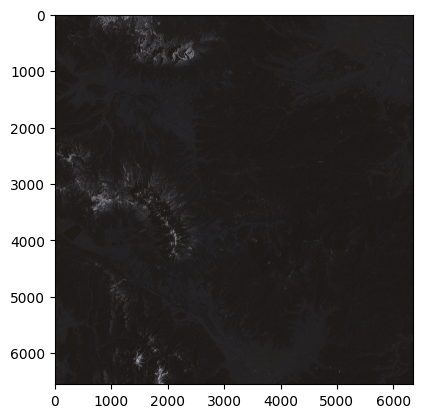

In [22]:
plt.imshow(Z_sharp_img[:,:,:3]/65535)

In [44]:

og_res = cv2.resize(Z_sharp_img, (Z_sharp_img.shape[1] // 2,Z_sharp_img.shape[0] // 2),interpolation=cv2.INTER_AREA)

In [45]:
og_res.shape

(3276, 3178, 4)

In [46]:
og_res = cv2.resize(og_res,(3174,3275),interpolation=cv2.INTER_AREA)

In [47]:
og_res.shape

(3275, 3174, 4)

In [34]:
# Target dimensions (1/2 height and width)
crop_height_ = ms_image.shape[0] // 2
crop_width_ = ms_image.shape[1] // 2

# Crop MS and PAN
comp_og = crop_center(np.transpose(ms_image,(2,0,1)), crop_width_, crop_height_).astype(np.float32)

In [35]:
comp_og.shape

(4, 3275, 3174)

In [38]:
lego = np.transpose(comp_og,(1,2,0))

In [39]:
lego.shape

(3275, 3174, 4)

In [48]:
sam_image, mean_sam = compute_sam(lego,og_res)
psnr = compute_quality_metrics(lego,og_res)
ergas = calculate_ergas(lego,og_res,4)
rmse = compute_quality_metrics(lego,og_res,False)

In [49]:
print(ergas)

20.052808436194116


In [50]:
print(rmse)

{'RMSE': 0.03885837170653804}


In [51]:
print(psnr)

{'PSNR': 45.888974815028035}


In [54]:
print(mean_sam)

0.019834608


In [104]:
og_res.shape

(3275, 3174, 4)

In [105]:
lego.shape

(3275, 3174, 4)

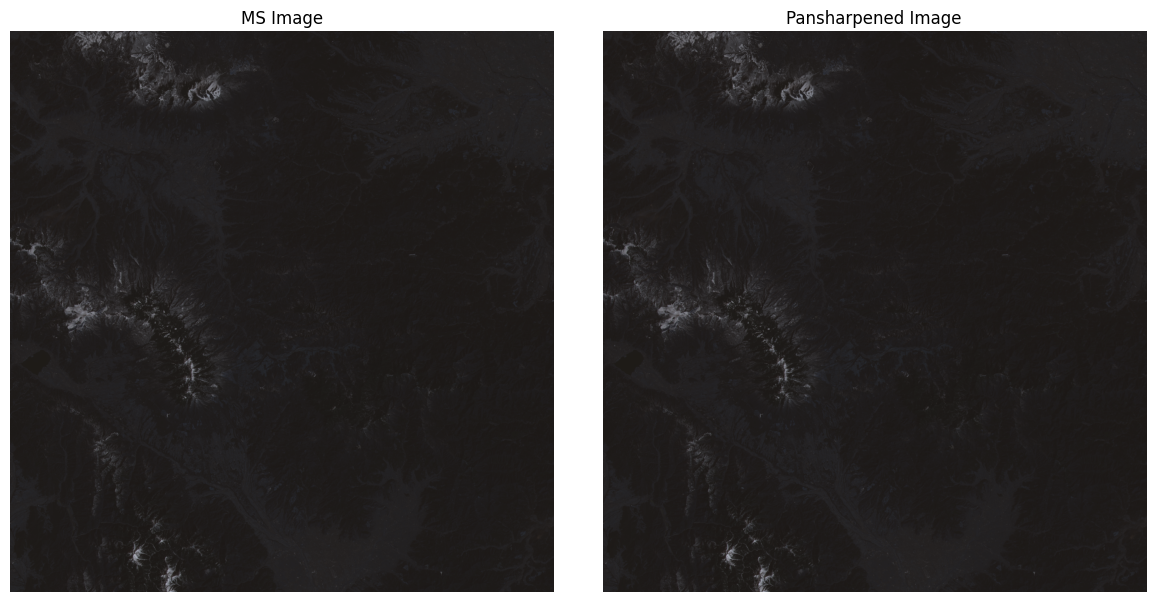

In [107]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

vmin = 0
vmax = 65535  # or np.percentile(image_rgb, 99) for contrast stretch

axs[0].imshow(lego[:, :, :3]/65535.0, vmin=vmin, vmax=vmax)
axs[0].set_title("MS Image")
axs[0].axis('off')

axs[1].imshow(og_res[:,:,:3]/65535.0, vmin=vmin, vmax=vmax)
axs[1].set_title("Pansharpened Image")
axs[1].axis('off')

plt.tight_layout()
plt.show()

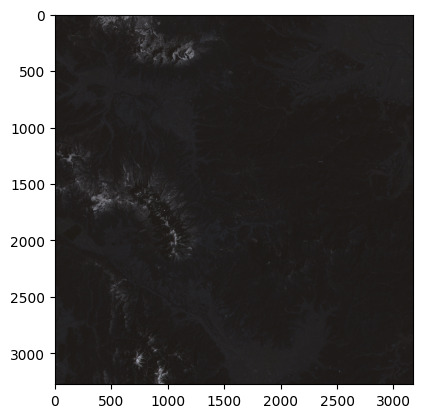

In [55]:
plt.imshow(lego[:,:,:3]/65535)

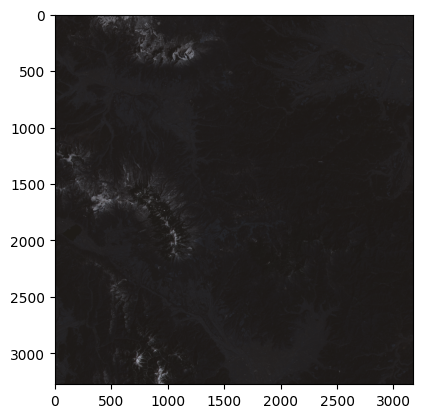

In [56]:
plt.imshow(og_res[:,:,:3]/65535)

In [109]:
image_rgb = og_res[:,:,:3]  # just R,G,B
image_rgb = np.clip(image_rgb, 0, 65535).astype(np.uint16)

tiff.imwrite("pansharpened_rgb.tif", image_rgb)

In [110]:
legorgb = lego[:,:,:3]  # just R,G,B
legorgb = np.clip(legorgb, 0, 65535).astype(np.uint16)

tiff.imwrite("msrgb.tif", legorgb)